In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from transformers import BertTokenizerFast, BertForTokenClassification, get_scheduler, AdamW
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
import zipfile

with zipfile.ZipFile('/content/generated-mountain-entity-recognition-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [5]:
df = pd.read_csv("/content/mountain_sentences_ner.csv")

In [6]:
df.fillna({'entity': 'none', 'start_idx': -1, 'end_idx': -1}, inplace=True)
df.head()

,original_sentence,new_sentence,entity,start_idx,end_idx
0,The mountains are a lush green in summer.,The Mount Kilimanjaro are a lush green in summer.,Mount Kilimanjaro,4.0,21.0
1,Mountain bike racing has caught on with young ...,Mountain bike racing has caught on with young ...,none,-1.0,-1.0
2,There are colossal mountains in the north.,There are colossal Makalu in the north.,Makalu,19.0,25.0
3,We are going to the mountains.,We are going to the Mount Aconcagua.,Mount Aconcagua,20.0,35.0
4,Mt. Everest is higher than any other mountain ...,Mt. Everest is higher than any other Pico de O...,Pico de Orizaba,37.0,52.0


In [7]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
def preprocess_ner_data_with_tokenizer(df, tokenizer, max_seq_length=128):
    """
    Preprocesses the dataset for NER by tokenizing, creating labels, and padding.

    Args:
        df (pd.DataFrame): Input dataframe with columns
                           ['original_sentence', 'new_sentence', 'entity', 'start_idx', 'end_idx'].
        tokenizer (transformers.BertTokenizerFast): Tokenizer for the model.
        max_seq_length (int): Maximum sequence length for tokenization.

    Returns:
        TensorDataset: A PyTorch dataset containing input IDs, attention masks, and labels.
    """
    input_ids, attention_masks, label_ids = [], [], []

    for _, row in df.iterrows():
        sentence = row['new_sentence']
        entity = row['entity']
        start = row['start_idx']
        end = row['end_idx']

        # Tokenize the sentence
        tokenized = tokenizer(sentence,
                              padding="max_length",
                              truncation=True,
                              return_offsets_mapping=True,
                              max_length=max_seq_length,
                              return_tensors="pt")

        # Get token offset mappings
        offset_mapping = tokenized.pop("offset_mapping")[0]
        labels = [label_to_id('O')] * len(offset_mapping)

        # Label assignment based on entity spans
        for idx, (start_offset, end_offset) in enumerate(offset_mapping):
            if start_offset >= start and end_offset <= end:
                if labels[idx - 1] == label_to_id('O') if idx > 0 else True:  # First entity token
                    labels[idx] = label_to_id('B-MOUNTAIN')
                else:
                    labels[idx] = label_to_id('I-MOUNTAIN')

        input_ids.append(tokenized['input_ids'][0])
        attention_masks.append(tokenized['attention_mask'][0])

        # Padding labels to match max_seq_length
        labels = labels + [label_to_id('O')] * (max_seq_length - len(labels))
        label_ids.append(torch.tensor(labels[:max_seq_length]))

    # Stack tensors and create TensorDataset
    input_ids = torch.stack(input_ids)
    attention_masks = torch.stack(attention_masks)
    label_ids = torch.stack(label_ids)

    return TensorDataset(input_ids, attention_masks, label_ids)

def label_to_id(label):
    if label == 'B-MOUNTAIN':
        return 1
    elif label == 'I-MOUNTAIN':
        return 2
    else:
        return 0  # 'O' for other tokens

    # Stack tensors and create TensorDataset
    input_ids = torch.stack(input_ids)
    attention_masks = torch.stack(attention_masks)
    label_ids = torch.stack(label_ids)

    return TensorDataset(input_ids, attention_masks, label_ids)

In [9]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", add_prefix_space=True)
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=3).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
train_dataset = preprocess_ner_data_with_tokenizer(train_df, tokenizer, max_seq_length=128)
test_dataset = preprocess_ner_data_with_tokenizer(test_df, tokenizer, max_seq_length=128)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [12]:
def train_and_test_model(model, train_loader, test_loader, optimizer, device):
    # Training Phase
    model.train()
    total_train_loss = 0
    all_preds = []
    all_labels = []

    for batch in train_loader:
        # Move batch data to device
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()

        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()

        # Collect predictions and true labels for accuracy calculation
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()
        all_preds.extend(logits.argmax(axis=-1).flatten())
        all_labels.extend(label_ids.flatten())

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = accuracy_score(all_labels, all_preds) * 100
    print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")

    # Evaluation Phase
    model.eval()
    total_test_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            # Move batch data to device
            batch = tuple(b.to(device) for b in batch)
            b_input_ids, b_input_mask, b_labels = batch

            # Forward pass
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

            loss = outputs.loss
            total_test_loss += loss.item()

            # Collect predictions and true labels for accuracy calculation
            logits = outputs.logits.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()
            all_preds.extend(logits.argmax(axis=-1).flatten())
            all_labels.extend(label_ids.flatten())

    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = accuracy_score(all_labels, all_preds) * 100
    print(f"Test Loss: {avg_test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")


In [13]:
epochs = 5
metrics = []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch + 1}\n")
    train_and_test_model(
        model=model,
        train_loader=train_dataloader,
        test_loader=test_dataloader,
        optimizer=optimizer,
        device=device
    )

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1

Train Loss: 0.0404 | Train Accuracy: 98.71%


 20%|██        | 1/5 [00:35<02:21, 35.37s/it]

Test Loss: 0.0002 | Test Accuracy: 100.00%
Epoch: 2

Train Loss: 0.0004 | Train Accuracy: 100.00%


 40%|████      | 2/5 [01:10<01:45, 35.23s/it]

Test Loss: 0.0001 | Test Accuracy: 100.00%
Epoch: 3

Train Loss: 0.0002 | Train Accuracy: 100.00%


 60%|██████    | 3/5 [01:47<01:11, 35.95s/it]

Test Loss: 0.0001 | Test Accuracy: 100.00%
Epoch: 4

Train Loss: 0.0001 | Train Accuracy: 100.00%


 80%|████████  | 4/5 [02:25<00:36, 36.93s/it]

Test Loss: 0.0001 | Test Accuracy: 100.00%
Epoch: 5

Train Loss: 0.0001 | Train Accuracy: 100.00%


100%|██████████| 5/5 [03:03<00:00, 36.68s/it]

Test Loss: 0.0000 | Test Accuracy: 100.00%


In [14]:
def predict(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            # Move batch data to device
            batch = tuple(b.to(device) for b in batch)
            b_input_ids, b_input_mask, b_labels = batch

            # Forward pass
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

            # Get predictions and collect true labels
            logits = outputs.logits.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()

            all_preds.extend(logits.argmax(axis=-1).flatten())  # Predicted labels
            all_labels.extend(label_ids.flatten())  # True labels

    return all_preds, all_labels


predictions, true_labels = predict(model, test_dataloader, device)

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(true_labels, predictions, label_names):
    """
    Generates and displays a confusion matrix for the given true and predicted labels.

    Args:
    - true_labels (list): Ground truth labels.
    - predictions (list): Predicted labels.
    - label_names (list): Names of the labels in order (e.g., ['O', 'B-MOUNTAIN', 'I-MOUNTAIN']).
    """
    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predictions, labels=range(len(label_names)))

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap="Blues", values_format="d")
    disp.ax_.set_title("Confusion Matrix")
    disp.ax_.set_xlabel("Predicted Labels")
    disp.ax_.set_ylabel("True Labels")
    plt.show()


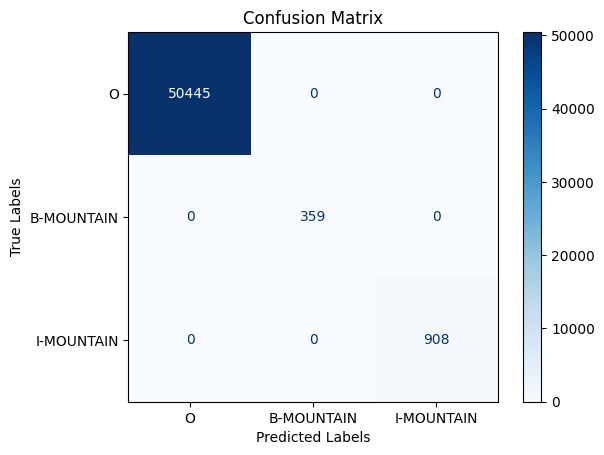

In [16]:
# Define label names
label_names = ['O', 'B-MOUNTAIN', 'I-MOUNTAIN']

# Call predict function to get predictions and true labels
predictions, true_labels = predict(model, test_dataloader, device)

# Plot confusion matrix
plot_confusion_matrix(true_labels, predictions, label_names)


In [18]:
from pathlib import Path

path = Path("models")
path.mkdir(parents=True, exist_ok=True)

model_name = "model.pth"

save = path / model_name

torch.save(obj = model.state_dict(), f=save)

In [4]:
# Let do some inference, we will import neccessary functions from inference.py

from inference import setup_model, load_model, predict, print_predictions

tokenizer, model = setup_model(model_name='bert-base-uncased')

# Load the trained model
model = load_model('/content/models/model.pth', model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

texts = [
    "We visited the Sierra Nevada during our road trip.",
    "Mount Denali, the highest peak in North America, is in Alaska.",
    "Mount Aconcagua is the tallest peak in South America.",
]

predictions = predict(texts, tokenizer, model, device)
print_predictions(predictions)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/content/inference.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you st

Model loaded from /content/models/model.pth

Prediction for sentence:
Token: we, Label: O
Token: visited, Label: O
Token: the, Label: O
Token: sierra, Label: B-MOUNTAIN
Token: nevada, Label: I-MOUNTAIN
Token: during, Label: O
Token: our, Label: O
Token: road, Label: O
Token: trip, Label: O
Token: ., Label: O

Prediction for sentence:
Token: mount, Label: O
Token: den, Label: I-MOUNTAIN
Token: ##ali, Label: I-MOUNTAIN
Token: ,, Label: O
Token: the, Label: O
Token: highest, Label: O
Token: peak, Label: O
Token: in, Label: O
Token: north, Label: O
Token: america, Label: O
Token: ,, Label: O
Token: is, Label: O
Token: in, Label: O
Token: alaska, Label: O
Token: ., Label: O

Prediction for sentence:
Token: mount, Label: O
Token: ac, Label: I-MOUNTAIN
Token: ##on, Label: I-MOUNTAIN
Token: ##ca, Label: I-MOUNTAIN
Token: ##gua, Label: I-MOUNTAIN
Token: is, Label: O
Token: the, Label: O
Token: tallest, Label: O
Token: peak, Label: O
Token: in, Label: O
Token: south, Label: O
Token: america, Lab